In [1]:
versioninfo()

Julia Version 0.5.2
Commit f4c6c9d4bb (2017-05-06 16:34 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-4750HQ CPU @ 2.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


# Kendall's Process

## Table of Contents

1. [Background](#Background)
2. [Introducing BioSimulator](#Introducing-BioSimulator)
    1. [Building a Model](#Building-a-Model)
    2. [Petri Nets](#Petri-Nets)
    3. [Simulation](#Simulation)
3. [Visualizing the Simulating Data](#Visualizing-the-Simulation-Data)
    1. [Trajectory](#Trajectory)
    2. [Mean Trajectory](#Mean-Trajectory)
    3. [Histogram](#Histogram)
4. [Benchmarks](#Benchmarks)
    1. [SSA](#SSA)
    2. [FRM](#FRM)
    3. [NRM](#NRM)
    4. [ODM](#ODM)
    5. [SAL](#SAL)

## Background

First we review the mathematical background underlying Kendall's Process. Additional details may be found in Chapter 8, Section 7 of Dr. Kenneth Lange's *Applied Probability*, among many other resources.

Kendall's process is a birth-death-immigration process with a single particle type $X$. Within a given volume $\Omega$, a particle may either (1) experience a budding event $X \to X + X$ with rate $\alpha(t)$ per particle per time, or (2) decay $X \to \emptyset$ with rate $\mu(t)$ per particle per time. Additionally, (3) particles outside $\Omega$ may enter the system $\emptyset \to X$ according to a Poisson process with rate $\nu(t)$ per unit time. We assume that the system is well-mixed; i.e. spatial homogeneity.

The probabilities of being in state $j$ given the system was in state $i$ at time $t$, $p_{i,j}(t)$, are summarized by the forward equations
\begin{align*}
    \frac{d}{dt} p_{i,0}(t) &= -\nu p_{i0}(t) + \mu p_{i1}(t) \\
    \frac{d}{dt} p_{i,j}(t) &= -[\nu + j \alpha + j \mu] p_{i,j}(t) + [\nu + (j - 1) \alpha] p_{i,j-1}(t) + (j + 1) \mu p_{i,j+1}(t)
\end{align*}
where we assume the rates $\alpha(t)$, $\mu(t)$, and $\nu(t)$ are homogenous in time. This simplifying assumption permits the analytic solution for the mean number of particles:
\\[
m_{x_{0}}(t) = x_{0} e^{(\alpha - \mu) t} + \frac{\nu}{\alpha - \mu} \left( e^{(\alpha - \mu) t} - 1 \right),
\\]
where $x_{0}$ is the initial number of particles.

## Introducing BioSimulator

### Building a Model

First we load `BioSimulator.jl` and the model implemented by the function `kendall`.

In [2]:
using BioSimulator
include("../test/test_models.jl");

See `test_models.jl` under the `test/` directory to see how the model is implemented. A `model` is initialized by constructing a `Network` object. Each particle/species in the model is defined using `model <= Species(...)`; each reaction is defined using `model <= Reaction(...)`.

In [3]:
?Species

search: Species species_list n_species specialized_bitwise_unary



```
Species(id, [value=0])
```

Define a `Species` with a `name` and initial population `value`.


In [4]:
?Reaction

search: Reaction reaction_list n_reactions



```
Reaction(name, rate, formula)
```

Define a `Reaction` with a `name`, a stochastic `rate` constant, and a `formula`.

The `formula` should use `Species` from a `Network`. Multiple reactants are separated by a `+` symbol; similarly for products. Reactants and products are separated by a `-->` symbol. Refer to the examples below:

# Examples

  * Reaction("birth", 1.0, "X –> X + X")
  * Reaction("death", 0.5, "X –> 0") # no products
  * Reaction("immigration", 0.5, "0 –> X") # no reactants


In [5]:
; cat ../test/test_models.jl

"""
```
kendall([i=5], [α=2.0], [μ=1.0], [ν=0.5])
```
Kendall's birth-death-immigration process.

- `i`: initial number of particles
- `α`: birth rate
- `μ`: death rate
- `ν`: immigration rate
"""
function kendall(
  i :: Integer = 5,
  α :: Float64 = 2.0,
  μ :: Float64 = 1.0,
  ν :: Float64 = 0.5)
  m = Network("Kendall's Process")

  m <= Species("X", i)

  m <= Reaction("birth",       α, "X --> X + X")
  m <= Reaction("death",       μ, "X --> 0")
  m <= Reaction("immigration", ν, "0 --> X")

  return m
end

"""
```
linear(M, x0)
```
A linear chain system of `M` particle types, starting from `x0` initial particles of type 1. Taken from Cao, Li, & Petzold 2004.

- `M`: the number of particle types
- `x0`: the initial number of particles
"""
function linear(
  M  :: Integer,
  x0 :: Integer)
  m = Network("linear chain ($M)")

  m <= Species("S1", x0)

  for i = 2:M
    m <= Species("S$(i)", 0)
  end

  for i = 1:M-1
    m <= Reaction("R$(i)", 1.0, "S$(i) --> S$(i+1)")
    m <= Reacti

Note that we can specify initial conditions and change parameters:

In [6]:
?kendall

search: corkendall backend_name



```
kendall([i=5], [α=2.0], [μ=1.0], [ν=0.5])
```

Kendall's birth-death-immigration process.

  * `i`: initial number of particles
  * `α`: birth rate
  * `μ`: death rate
  * `ν`: immigration rate


We'll specify the default values explicitly, but note that we could have just used `kendall()`.

In [7]:
X0 = 5
α  = 2.0
μ  = 1.0
ν  = 0.5

model = kendall(X0, α, μ, ν)

[ Model: Kendall's Process ]
 no. species:    1
 no. reactions:  3

In [8]:
model.species_list

Dict{Symbol,BioSimulator.Species} with 1 entry:
  :X => 5…

In [9]:
model.reaction_list

Dict{Symbol,BioSimulator.Reaction} with 3 entries:
  :immigration => ∅ --> X
  :birth       => X --> 2 X
  :death       => X --> ∅

### Petri Nets

One can visualize a model as a *Petri Net* using `visualize`. Each `Species` and `Reaction` is rendered as a blue and red box, respectively. A `Species` is a *reactant* in a `Reaction` if there is an arrow from its box to a reaction; similarly, it is a *product* of a reaction if the direction is reversed. Numbers adjacent to arrows represent the stoichiometric coefficient in the reaction. If no number is present, it is assumed to be $1$.

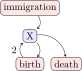

In [10]:
visualize(model)

### Simulation

We'll use the Stochastic Simulation Algorithm/Gillespie's Method. We specify the simulation parameters

> `time`: the end simulation time; we'll simulate until $t = 4$.

> `epochs`: the number of bins used to discretize the interval $[0, t]$.

> `trials`: the number of times to repeat the simulation.

The `simulate` method executes the simulation and returns a `SimData` type storing the history for each independent realization.

In [11]:
# warm-up
@time result = simulate(model, SSA, time = 4.0, epochs = 40, trials = 1)

# simulate
@time result = simulate(model, SSA, time = 4.0, epochs = 40, trials = 10_000)

  3.557802 seconds (4.90 M allocations: 209.378 MB, 3.44% gc time)
  0.881776 seconds (351 allocations: 20.844 KB)


SimData{1,41,10000}
 * species  = ("X",)
 * time     = 4.0
 * epochs   = 41
 * trials   = 10000

## Visualizing the Simulation Data

Now we compute the analytic solution.

In [12]:
function kendall_mean(i, t, α, μ, ν)
  x = exp((α - μ) * t)
  return i * x + ν / (α - μ) * (x - 1)
end

t = result.t_index
X = kendall_mean(X0, t, α, μ, ν);

### Trajectory
We plot independent realizations using `Trajectory` which takes the arguments

> `result`: A `SimData` type,

> `id`: a label for a particular species, and

> `trial`: a label for a particular realization.

Here we plot the first $5$ realizations for $X$ against the analytic solution.

In [13]:
sample_traj = plot(t, X, label = "analytic")
for i in 1:5
    plot!(sample_traj, Trajectory(result, "X", i), label = "trial $(i)")
end
sample_traj

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 250 
 
 
 500 
 
 
 750 
 
 
 time 
 
 
 population size 
 
<polyline clip-path="url(#clip02)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,367.733 53.189,367.509 67.0079,367.263 80.8268,366.99 94.6457,366.689 108.465,366.356 122.283,365.989 136.102,365.582 149.921,365.133 163.74,364.636 
 177.559,364.087 191.378,363.481 205.197,362.811 219.016,362.07 232.835,361.251 246.654,360.347 260.472,359.347 274.291,358.242 288.11,357.02 301.929,355.671 
 315.748,354.179 329.567,352.531 343.386,350.709 357.205,348.695 371.024,346.47 384.843,344.011 398.661,341.293 412.48,338.289 426.299,334.969 440.118,331.3 
 453.937,327.245 467.756,322.764 481.575,317.812 495.394,312.338 509.213,306.289 523.031,299.604 536.85,292.216 550.669,284.051 564.488,275.027 578.307,265.054 
 592.126,254.032 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,367.733 39.3701,367.347 53.189,367.347 53.189,367.733 67.0079,367.733 67.0079,366.575 80.8268,366.575 80.8268,364.261 94.6457,364.261 
 108.465,364.261 108.465,362.333 122.283,362.333 122.283,361.176 136.102,361.176 136.102,358.476 149.921,358.476 149.921,357.319 163.74,357.319 163.74,355.776 
 177.559,355.776 177.559,354.233 191.378,354.233 191.378,350.762 205.197,350.762 205.197,348.062 219.016,348.062 219.016,346.519 232.835,346.519 232.835,345.362 
 246.654,345.362 246.654,341.891 260.472,341.891 260.472,339.962 274.291,339.962 274.291,334.177 288.11,334.177 288.11,329.548 301.929,329.548 301.929,326.463 
 315.748,326.463 315.748,319.52 329.567,319.52 329.567,312.577 343.386,312.577 343.386,306.02 357.205,306.02 357.205,296.378 371.024,296.378 371.024,290.978 
 384.843,290.978 384.843,280.179 398.661,280.179 398.661,270.15 412.48,270.15 412.48,262.051 426.299,262.051 426.299,250.48 440.118,250.48 440.118,240.066 
 453.937,240.066 453.937,224.252 467.756,224.252 467.756,203.038 481.575,203.038 481.575,185.682 495.394,185.682 495.394,165.24 509.213,165.24 509.213,142.483 
 523.031,142.483 523.031,115.484 536.85,115.484 536.85,96.9708 550.669,96.9708 550.669,74.9859 564.488,74.9859 564.488,49.144 578.307,49.144 578.307,7.87402 
 592.126,7.87402 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,367.733 39.3701,366.19 53.189,366.19 53.189,365.418 67.0079,365.418 80.8268,365.418 80.8268,365.033 94.6457,365.033 94.6457,365.418 
 108.465,365.418 108.465,365.033 122.283,365.033 136.102,365.033 136.102,361.947 149.921,361.947 149.921,360.404 163.74,360.404 163.74,360.019 
 177.559,360.019 177.559,358.476 191.378,358.476 191.378,357.319 205.197,357.319 205.197,354.233 219.016,354.233 219.016,352.69 232.835,352.69 232.835,350.376 
 246.654,350.376 246.654,346.519 260.472,346.519 260.472,341.119 274.291,341.119 274.291,334.948 288.11,334.948 288.11,333.791 301.929,333.791 301.929,329.934 
 315.748,329.934 315.748,326.463 329.567,326.463 329.567,322.22 343.386,322.22 343.386,318.749 357.205,318.749 357.205,315.663 371.024,315.663 371.024,307.949 
 384.843,307.949 384.843,303.706 398.661,303.706 398.661,294.449 412.48,294.449 412.48,290.592 426.299,290.592 426.299,285.193 440.118,285.193 440.118,271.307 
 453.937,271.307 453.937,260.122 467.756,260.122 467.756,252.022 481.575,252.022 481.575,237.751 495.394,237.751 495.394,220.781 509.213,220.781 509.213,203.81 
 523.031,203.81 523.031,183.753 536.85,183.753 536.85,168.325 550.669,168.325 550.669,148.269 564.488,148.269 564.488,125.898 578.307,125.898 578.307,103.142 
 592.126,103.142 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#c271d2; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,367.733 39.3701,368.504 53.189,368.504 67.0079,368.504 67.0079,368.118 80.8268,368.118 80.8268,368.504 94.6457,368.504 
 108.465,368.50

### Mean Trajectory

Now we compare the average over all $10^5$ trajectories to the analytic solution for the mean. The shaded region corresponds to one standard deviation away from the mean.

In [14]:
mean_traj = plot(MeanTrajectory(result, "X"), label = "simulation")
plot!(mean_traj, t, X, label = "analytic")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 500 
 
 
 time 
 
 
 mean population size 
 
<polygon clip-path="url(#clip02)" points="
39.3701,368.006 53.189,368.504 67.0079,368.497 80.8268,368.452 94.6457,368.316 108.465,368.172 122.283,368.024 136.102,367.851 149.921,367.63 163.74,367.381 
 177.559,367.127 191.378,366.82 205.197,366.474 219.016,366.135 232.835,365.719 246.654,365.287 260.472,364.796 274.291,364.212 288.11,363.596 301.929,362.86 
 315.748,362.115 329.567,361.265 343.386,360.312 357.205,359.26 371.024,358.116 384.843,356.84 398.661,355.414 412.48,353.791 426.299,352.109 440.118,350.197 
 453.937,348.127 467.756,345.742 481.575,343.139 495.394,340.348 509.213,337.131 523.031,333.71 536.85,329.994 550.669,325.816 564.488,321.124 578.307,315.966 
 592.126,310.732 592.126,7.87402 578.307,42.5609 564.488,73.8588 550.669,102.545 536.85,128.173 523.031,151.542 509.213,172.797 495.394,191.849 481.575,209.116 
 467.756,224.936 453.937,238.906 440.118,251.675 426.299,263.141 412.48,273.723 398.661,283.136 384.843,291.803 371.024,299.434 357.205,306.502 343.386,312.894 
 329.567,318.672 315.748,323.904 301.929,328.557 288.11,332.794 274.291,336.616 260.472,340.085 246.654,343.236 232.835,346.107 219.016,348.649 205.197,351.032 
 191.378,353.123 177.559,355.062 163.74,356.834 149.921,358.409 136.102,359.836 122.283,361.081 108.465,362.278 94.6457,363.375 80.8268,364.38 67.0079,365.325 
 53.189,366.192 39.3701,368.006 
 " fill="#009af9" fill-opacity="0.3"/>
<polyline clip-path="url(#clip02)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,368.006 53.189,367.348 67.0079,366.911 80.8268,366.416 94.6457,365.846 108.465,365.225 122.283,364.552 136.102,363.843 149.921,363.019 163.74,362.107 
 177.559,361.094 191.378,359.971 205.197,358.753 219.016,357.392 232.835,355.913 246.654,354.262 260.472,352.441 274.291,350.414 288.11,348.195 301.929,345.709 
 315.748,343.01 329.567,339.968 343.386,336.603 357.205,332.881 371.024,328.775 384.843,324.321 398.661,319.275 412.48,313.757 426.299,307.625 440.118,300.936 
 453.937,293.516 467.756,285.339 481.575,276.128 495.394,266.099 509.213,254.964 523.031,242.626 536.85,229.084 550.669,214.18 564.488,197.492 578.307,179.264 
 592.126,159.303 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,368.006 53.189,367.595 67.0079,367.141 80.8268,366.64 94.6457,366.085 108.465,365.473 122.283,364.795 136.102,364.047 149.921,363.22 163.74,362.306 
 177.559,361.296 191.378,360.179 205.197,358.945 219.016,357.582 232.835,356.075 246.654,354.409 260.472,352.568 274.291,350.534 288.11,348.286 301.929,345.801 
 315.748,343.055 329.567,340.02 343.386,336.666 357.205,332.959 371.024,328.863 384.843,324.335 398.661,319.332 412.48,313.802 426.299,307.691 440.118,300.936 
 453.937,293.472 467.756,285.222 481.575,276.105 495.394,266.029 509.213,254.893 523.031,242.587 536.85,228.985 550.669,213.954 564.488,197.341 578.307,178.981 
 592.126,158.691 
 "/>
 
 
 
 
 
 simulation 
 
 
 
 analytic

### Histogram

Plotting the distribution of $X$ at $t = 4$ reveals extinction as a common event. This is an impossible event in the deterministic model
\\[ \frac{dx}{dt} = \tilde{\alpha} x^{2} - \tilde{\mu} x + \tilde{\nu}, \\]
unless the death rate dominates the birth rate. Here $\tilde{\alpha}$, $\tilde{\mu}$, and $\tilde{\nu}$ are scaled versions of the stochastic rates. This is because stochastic rate constants have a volume dependence; i.e. they must account for how likely particles collide to react.

In [15]:
histo = plot(Histogram(result, "X", 4.0))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 1000 
 
 
 2000 
 
 
 0 
 
 
 500 
 
 
 1000 
 
 
 1500 
 
 
 2000 
 
 
 population size 
 
 
 frequency 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 X

## Benchmarks

The following benchmarks measure how much compute time is required to generate a single trajectory. Note that there is significant overhead from using the `gcsample=true` option.

In [16]:
using BenchmarkTools

### SSA

In [17]:
@benchmark simulate($kendall(), SSA, time = 4.0, epochs = 40) gcsample=true

BenchmarkTools.Trial: 
  memory estimate:  27.56 KiB
  allocs estimate:  423
  --------------
  minimum time:     702.886 μs (0.00% GC)
  median time:      772.851 μs (0.00% GC)
  mean time:        825.347 μs (0.00% GC)
  maximum time:     1.070 ms (0.00% GC)
  --------------
  samples:          10
  evals/sample:     1

### FRM

In [18]:
@benchmark simulate($kendall(), FRM, time = 4.0, epochs = 40) gcsample=true

BenchmarkTools.Trial: 
  memory estimate:  27.56 KiB
  allocs estimate:  423
  --------------
  minimum time:     686.497 μs (0.00% GC)
  median time:      801.375 μs (0.00% GC)
  mean time:        836.053 μs (0.00% GC)
  maximum time:     996.362 μs (0.00% GC)
  --------------
  samples:          10
  evals/sample:     1

### NRM

In [19]:
@benchmark simulate($kendall(), NRM, time = 4.0, epochs = 40) gcsample=true

BenchmarkTools.Trial: 
  memory estimate:  28.34 KiB
  allocs estimate:  430
  --------------
  minimum time:     596.234 μs (0.00% GC)
  median time:      1.073 ms (0.00% GC)
  mean time:        1.102 ms (0.00% GC)
  maximum time:     1.774 ms (0.00% GC)
  --------------
  samples:          10
  evals/sample:     1

### ODM

In [20]:
@benchmark simulate($kendall(), ODM, time = 4.0, epochs = 40) gcsample=true

BenchmarkTools.Trial: 
  memory estimate:  28.30 KiB
  allocs estimate:  434
  --------------
  minimum time:     698.758 μs (0.00% GC)
  median time:      938.300 μs (0.00% GC)
  mean time:        951.676 μs (0.00% GC)
  maximum time:     1.366 ms (0.00% GC)
  --------------
  samples:          9
  evals/sample:     1

### SAL

In [21]:
@benchmark simulate($kendall(), SAL, time = 4.0, epochs = 40) gcsample=true

BenchmarkTools.Trial: 
  memory estimate:  28.23 KiB
  allocs estimate:  430
  --------------
  minimum time:     590.366 μs (0.00% GC)
  median time:      707.590 μs (0.00% GC)
  mean time:        767.801 μs (0.00% GC)
  maximum time:     965.200 μs (0.00% GC)
  --------------
  samples:          10
  evals/sample:     1